In [1]:
import sys  
sys.path.insert(0, './../')
import numpy as np
import bbdc2021 as bbdc
import pandas as pd
from importlib import reload
reload(bbdc)
import tensorflow as tf
from keras import layers
import keras
from keras import backend as K
import matplotlib.pyplot as plt
from matplotlib import colors 
import evaluation.evaluate as evaluate
from tqdm import tqdm

In [2]:
np.random.seed(1)
tf.random.set_seed(1)
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"

In [3]:
def load_audio_for_classification(fileListName, datasetName, dataDirectory, pathToDataDir="./../data/", overallLength = 10, partLength=1):
    labelDf = pd.read_csv(pathToDataDir+fileListName)
    labelDf = labelDf.replace({"event_label": bbdc.LABEL_DICT})
    labelDf['duration'] = labelDf.offset - labelDf.onset
    
    first_file_string = '/' + labelDf['filename'][0][:-4] + '.csv'
    ## Features aller Files laden
    X = []
    Y = []
    fileList = []
    first_file_string = '/'+dataDirectory+'/' + labelDf['filename'][0][:-4] + '.csv'
    timepoints = np.genfromtxt(pathToDataDir+datasetName+first_file_string, delimiter=',')[:, 0]
    sizeOfSequences = int(partLength/overallLength*len(timepoints))
    currentFile = ""
    for index, row in tqdm(labelDf.iterrows()):
        if currentFile!=row["filename"]:
            currentFile = row["filename"].replace(".wav", ".csv")
            features = np.genfromtxt(pathToDataDir + datasetName + dataDirectory+currentFile, delimiter=',')
        partOfFeatures = features[np.where(np.logical_and(timepoints >= row["onset"],timepoints <= row["offset"]))]
        if len(partOfFeatures)<=sizeOfSequences:
            indices = np.where(np.logical_and(timepoints >= row["onset"],timepoints <= row["offset"]))[0]
            fileList.append(currentFile)
            X.append(features[indices[0]:indices[0]+sizeOfSequences, 1:])
            y = np.zeros(len(bbdc.LABEL_DICT))
            y[row["event_label"]]=1
            Y.append(y)
        elif len(partOfFeatures)>sizeOfSequences:
            fileList.append(currentFile)
            fileList.append(currentFile)
            X.append(partOfFeatures[:sizeOfSequences, 1:])
            X.append(partOfFeatures[-sizeOfSequences:, 1:])
            y = np.zeros(len(bbdc.LABEL_DICT))
            y[row["event_label"]]=1
            Y.append(y)
            Y.append(y)
    return np.array(X), np.array(Y), fileList

In [29]:
X_train_a, Y_train_a, trainFileList_a = bbdc.load_audioset("long_unbalanced_train_segments.csv", "unbalanced_fft_mel_l04_o02495_f32/", pathToDataDir="./../google_audioset/googleData/fft/")
X_validation_a, Y_validation_a, validationFileList_a = bbdc.load_audioset("long_balanced_train_segments.csv", "balanced_fft_mel_l04_o02495_f32/", pathToDataDir="./../google_audioset/googleData/fft/")
X_test_a, Y_test_a, testFileList_a = bbdc.load_audioset("long_eval_segments.csv", "eval_fft_mel_l04_o02495_f32/", pathToDataDir="./../google_audioset/googleData/fft/")

16186it [08:32, 31.57it/s]
573it [00:19, 29.54it/s]
585it [00:19, 29.70it/s]


In [30]:
X_train_new = np.append(X_train_a, X_validation_a, axis=0)
X_train_new = np.append(X_train_new, X_test_a, axis=0)
Y_train_new = np.append(Y_train_a[:,1:], Y_validation_a[:,1:], axis=0)
Y_train_new = np.append(Y_train_new, Y_test_a[:,1:], axis=0)

shuffledIndices = np.random.permutation(X_train_new.shape[0])
X_train_new = X_train_new[shuffledIndices]
Y_train_new = Y_train_new[shuffledIndices]
length = len(shuffledIndices)
X_validation_new = X_train_new[int(0.8*length):int(0.9*length)]
Y_validation_new = Y_train_new[int(0.8*length):int(0.9*length)]
X_test_new = X_train_new[int(0.9*length):]
Y_test_new = Y_train_new[int(0.9*length):]
X_train_new = X_train_new[:int(0.8*length)]
Y_train_new = Y_train_new[:int(0.8*length)]

In [4]:
X_train, Y_train, trainFileList = load_audio_for_classification("train.csv", pathToDataset, "dev/")
X_validation, Y_validation, validationFileList = load_audio_for_classification("validation.csv", pathToDataset, "dev/")
X_test, Y_test, testFileList = load_audio_for_classification("test.csv", pathToDataset, "dev/")

24009it [05:09, 77.51it/s]
3047it [00:38, 79.43it/s]
2988it [00:36, 82.28it/s]


In [11]:
channels = [32, 64, 30]
numClasses=12
padding = "same"
input_layer = layers.Input(shape=(None, 32))
#input_layer = layers.Input(shape=X_train_new[0].shape)
x = input_layer
x = layers.LSTM(100)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(numClasses, activation="softmax")(x)

model = keras.models.Model(inputs=input_layer, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 32)]        0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_2 (Dense)              (None, 13)                429       
Total params: 66,961
Trainable params: 66,961
Non-trainable params: 0
_________________________________________________________

In [7]:
channels = [25, 20, 15]
numClasses=12
padding = "same"
input_layer = layers.Input(shape=(None, 32))
#input_layer = layers.Input(shape=X_train_new[0].shape)
x = input_layer
x = layers.Conv1D(channels[0], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.Conv1D(channels[0], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D()(x)

x = layers.Conv1D(channels[1], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.Conv1D(channels[1], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.Conv1D(channels[1], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D()(x)

x = layers.Conv1D(channels[2], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.Conv1D(channels[2], kernel_size=3, padding=padding, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(numClasses, kernel_size=1, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Activation(keras.activations.softmax)(x)

model = keras.models.Model(inputs=input_layer, outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 32)]        0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 25)          2425      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 25)          1900      
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 25)          100       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 25)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 20)          1520      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 20)          1220

In [8]:
opt = keras.optimizers.Adam(learning_rate=0.001)
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(X_train, Y_train[:,1:], batch_size=64, epochs=100, shuffle=True, validation_data=(X_validation, Y_validation[:,1:]), callbacks=[checkpoint])

Epoch 1/100
563/563 [==============================] - 6s 9ms/step - loss: 2.1438 - mae: 0.1370 - accuracy: 0.2877 - val_loss: 1.5474 - val_mae: 0.1056 - val_accuracy: 0.4958

Epoch 00001: val_loss improved from inf to 1.54736, saving model to model.h5
Epoch 2/100
563/563 [==============================] - 6s 10ms/step - loss: 1.4168 - mae: 0.1006 - accuracy: 0.5450 - val_loss: 1.2434 - val_mae: 0.0869 - val_accuracy: 0.6041

Epoch 00002: val_loss improved from 1.54736 to 1.24336, saving model to model.h5
Epoch 3/100
563/563 [==============================] - 5s 9ms/step - loss: 1.1645 - mae: 0.0843 - accuracy: 0.6330 - val_loss: 1.0736 - val_mae: 0.0785 - val_accuracy: 0.6588

Epoch 00003: val_loss improved from 1.24336 to 1.07360, saving model to model.h5
Epoch 4/100
563/563 [==============================] - 5s 8ms/step - loss: 1.0145 - mae: 0.0741 - accuracy: 0.6792 - val_loss: 0.9590 - val_mae: 0.0681 - val_accuracy: 0.7011

Epoch 00004: val_loss improved from 1.07360 to 0.95903, 

In [31]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(X_train_new, Y_train_new, batch_size=64, epochs=150, shuffle=True, validation_data=(X_validation_new, Y_validation_new), callbacks=[checkpoint])

Epoch 1/150
217/217 [==============================] - 15s 63ms/step - loss: 4.6381 - mae: 0.1134 - accuracy: 0.3486 - val_loss: 2.6861 - val_mae: 0.1096 - val_accuracy: 0.3858

Epoch 00001: val_loss improved from inf to 2.68610, saving model to model.h5
Epoch 2/150
217/217 [==============================] - 13s 61ms/step - loss: 2.2428 - mae: 0.1003 - accuracy: 0.4554 - val_loss: 2.0079 - val_mae: 0.1011 - val_accuracy: 0.4596

Epoch 00002: val_loss improved from 2.68610 to 2.00794, saving model to model.h5
Epoch 3/150
217/217 [==============================] - 13s 62ms/step - loss: 1.7762 - mae: 0.0971 - accuracy: 0.4985 - val_loss: 1.7914 - val_mae: 0.0964 - val_accuracy: 0.5035

Epoch 00003: val_loss improved from 2.00794 to 1.79143, saving model to model.h5
Epoch 4/150
217/217 [==============================] - 13s 61ms/step - loss: 1.6210 - mae: 0.0968 - accuracy: 0.5187 - val_loss: 1.6286 - val_mae: 0.0961 - val_accuracy: 0.5196

Epoch 00004: val_loss improved from 1.79143 to 1.

In [32]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(X_train, Y_train[:,1:], batch_size=64, epochs=100, shuffle=True, validation_data=(X_validation, Y_validation[:,1:]), callbacks=[checkpoint])

Epoch 1/100
563/563 [==============================] - 6s 9ms/step - loss: 2.7518 - mae: 0.0942 - accuracy: 0.4592 - val_loss: 1.7992 - val_mae: 0.0769 - val_accuracy: 0.5700

Epoch 00001: val_loss improved from inf to 1.79916, saving model to model.h5
Epoch 2/100
563/563 [==============================] - 5s 8ms/step - loss: 1.6437 - mae: 0.0735 - accuracy: 0.5953 - val_loss: 1.4385 - val_mae: 0.0695 - val_accuracy: 0.6210

Epoch 00002: val_loss improved from 1.79916 to 1.43847, saving model to model.h5
Epoch 3/100
563/563 [==============================] - 5s 9ms/step - loss: 1.3505 - mae: 0.0675 - accuracy: 0.6367 - val_loss: 1.2377 - val_mae: 0.0645 - val_accuracy: 0.6560

Epoch 00003: val_loss improved from 1.43847 to 1.23769, saving model to model.h5
Epoch 4/100
563/563 [==============================] - 5s 8ms/step - loss: 1.1742 - mae: 0.0626 - accuracy: 0.6700 - val_loss: 1.1055 - val_mae: 0.0605 - val_accuracy: 0.6859

Epoch 00004: val_loss improved from 1.23769 to 1.10552, s

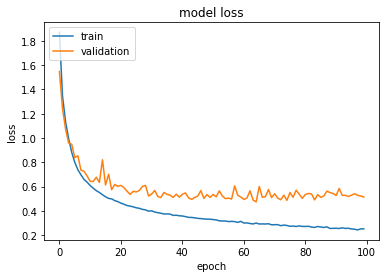

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

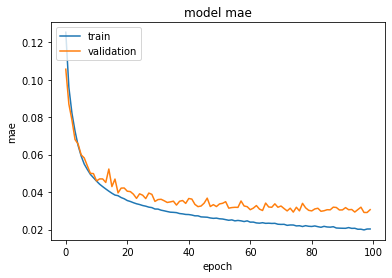

In [10]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

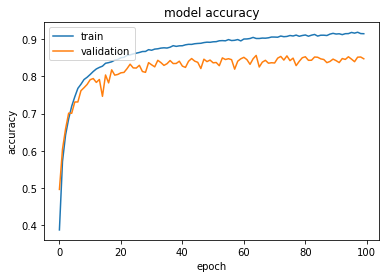

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
model.save("classificationBBDC_Data_100.h5")

In [ ]:
model = keras.models.load_model("model.h5")

In [13]:
prediction = model.predict(X_test)
scores = model.evaluate(X_test, Y_test[:,1:])

140/140 [==============================] - 0s 2ms/step - loss: 0.5247 - mae: 0.0307 - accuracy: 0.8474


# Prediction der Test-Daten

In [33]:
firstPredictionFile = "./../data/test.csv" #"../predictions/jannes/LP1d_Prediction_mel_pp_test.csv"
firstPrediction = pd.read_csv(firstPredictionFile)
pathToDataDir = "../data/"
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"
firstPrediction.head()

,filename,onset,offset,event_label
0,09001_mix.wav,1.151324,3.151324,Cough
1,09001_mix.wav,3.884321,5.884321,Cheering
2,09001_mix.wav,7.726865,9.726865,Meow
3,09002_mix.wav,0.232286,1.232286,Shout
4,09002_mix.wav,2.679677,4.679677,Camera


In [34]:
currentFile = ""
X = []
Y = []
for index, row in firstPrediction.iterrows():
    if currentFile!=row["filename"]:
        currentFile = row["filename"]
        features = np.genfromtxt(pathToDataDir + pathToDataset +"/dev/" + row["filename"].replace(".wav", ".csv"), delimiter=',')
    indices = np.where(np.logical_and(features[:,0]>=row["onset"], features[:,0]<=row["offset"]))[0]
    start = indices[0]
    end = indices[-1]
    while end-start<44:
        start = start-10
        end = end+10
        if end>=len(features):
            end = len(features)
        if start<0:
            start=0
    X.append(features[start:end, 1:])

In [35]:
secondPrediction = []
secondProbability = []
for i in range(len(X)):
    if X[i].shape[0]>=44:
        prediction = model.predict(np.array([X[i]]))[0]
        mostLikely = np.argsort(prediction)[-1]+1
        secondLikely = np.argsort(prediction)[-2]+1
        secondPrediction.append(mostLikely)
        secondProbability.append(secondLikely)
    else:
        secondPrediction.append("short")
        secondProbability.append("short")
        print("too short")

secondLabel = [bbdc.invLabelMap[pred] for pred in secondPrediction]
secondProbLabel = [bbdc.invLabelMap[pred] for pred in secondProbability]

In [36]:
secondPredictionDf = firstPrediction.copy()
secondPredictionDf["event_label"]=secondLabel
secondPredictionDf2 = firstPrediction.copy()
secondPredictionDf2["event_label"]=secondLabel
secondPredictionDf = secondPredictionDf.append(secondPredictionDf2)
secondPredictionDf.to_csv("../predictions/jannes/predictionWithTwoLabels.csv", index=False) 

In [37]:
print("Score was: ")
print(evaluate.evaluate(firstPredictionFile, "./../data/test.csv"))
print("Score now is: ")
print(evaluate.evaluate("../predictions/jannes/predictionWithTwoLabels.csv", "./../data/test.csv"))

Score was: 
(1.0, 'Valid file')
Score now is: 
(0.6735387687262137, 'Valid file')


# Prediction der Challenge-Daten

In [38]:
pathToDataDir = "../data/"
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"
firstPredictionFile = "../data/challenge_dummyWithTime.csv"
firstPrediction = pd.read_csv(firstPredictionFile)
firstPrediction.head()

,filename,onset,offset,event_label
0,10001_mix.wav,2.857143,3.834586,?
1,10001_mix.wav,5.488722,6.466165,?
2,10001_mix.wav,7.969925,8.546366,?
3,10001_mix.wav,9.573935,9.774436,?
4,10002_mix.wav,0.451128,3.483709,?


In [39]:
currentFile = ""
X = []
Y = []
for index, row in firstPrediction.iterrows():
    if currentFile!=row["filename"]:
        currentFile = row["filename"]
        features = np.genfromtxt(pathToDataDir + pathToDataset +"/eval/" + row["filename"].replace(".wav", ".csv"), delimiter=',')
    indices = np.where(np.logical_and(features[:,0]>=row["onset"], features[:,0]<=row["offset"]))[0]
    start = indices[0]
    end = indices[-1]
    while end-start<44:
        start = start-10
        end = end+10
        if end>=len(features):
            end = len(features)
        if start<0:
            start=0
    X.append(features[start:end, 1:])

In [40]:
secondPrediction = []
secondProbability = []
for i in range(len(X)):
    if X[i].shape[0]>=44:
        prediction = model.predict(np.array([X[i]]))[0]
        mostLikely = np.argsort(prediction)[-1]+1
        secondLikely = np.argsort(prediction)[-2]+1
        #if pred==0:
        #    secondPrediction.append("?")
        #else:
        secondPrediction.append(mostLikely)
        secondProbability.append(secondLikely)
    else:
        secondPrediction.append("short")
        secondProbability.append("short")
        print("too short")

secondLabel = [bbdc.invLabelMap[pred] for pred in secondPrediction]
secondProbLabel = [bbdc.invLabelMap[pred] for pred in secondProbability]
secondPredictionDf = firstPrediction.copy()
secondPredictionDf["event_label"]=secondLabel
secondPredictionDf["secondLikely_label"]=secondProbLabel
secondPredictionDf.to_csv("../predictions/jannes/secondPredictionChallengeWithSecondLikely.csv", index=False)